<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [328]:
%%capture
pip install pyswarms

In [329]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [330]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'
DIAS_OBSERVADOS = 600

In [331]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [332]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [333]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [334]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [335]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [336]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [337]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [338]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [339]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [340]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


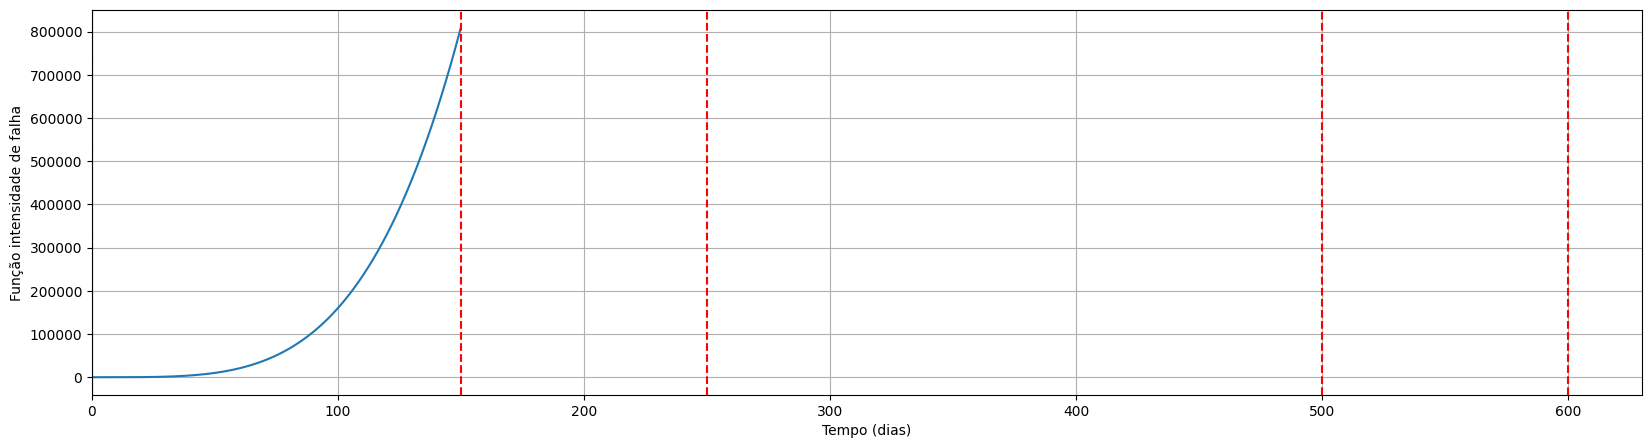

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [341]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [342]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [343]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-09-24 15:51:40,298 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   8%|▊         |8/100, best_cost=3.55e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 20, 38, 92, 120, 192, 271, 322, 402, 432, 591, 685]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 10663.209479064832, 475047.4467450177, 1624411.9624700698, 21329405.19611626, 29875677.337070845, 35123871.79929197, 126170972.70040338, 132175899.05156754, 1139094727.700354, 5313269739.618103, 5029647019.411324]
Custo =  223795732867.85513


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 55, 68, 93, 166, 197, 232, 244, 295, 330, 476, 563, 603, 635]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25

pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=3.55e+10<ipython-input-342-3f464f4b430c>:83: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=3.55e+10



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 64, 149, 216, 356, 423, 470, 611, 708]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 343597.38368, 11249536.973665468, 19674141.740751244, 181569791.2348002, 202103664.22550124, 282170275.13777596, 1208000941.5889728, 6124056019.268378, 5766844570.07453]
Custo =  255922004125.30182


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 46, 65, 192, 227, 289, 315, 357, 440, 493, 562, 604, 714]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.63212055

pyswarms.single.global_best:  44%|████▍     |44/100, best_cost=3.55e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 7, 147, 177, 318, 432, 462, 490, 528, 558, 594, 611, 694]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 5.378240000000001, 20294403.13021646, 21490927.6852301, 140156754.74894756, 343559442.68027776, 388134952.068349, 440036350.8359457, 537630895.0266453, 630584501.7851293, 1565125140.1200953, 1637576153.960981, 1784934577.2202315, 1472767284.5641756]
Custo =  188538006679.0922


Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 7, 54, 179, 320, 553, 596, 605, 705]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0

pyswarms.single.global_best:  52%|█████▏    |52/100, best_cost=3.55e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 3, 43, 70, 186, 350, 361, 416, 450, 504, 556, 597]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 0.07776000000000001, 41875.85735175083, 87618.8134259379, 18398248.73487495, 234973129.54831803, 240710677.23445246, 302253012.6157023, 310546472.6393302, 433980231.67034227, 466720951.49048525, 637763697.2834222, 649240606.3238019]
Custo =  57113976436.661736


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 47, 62, 255, 310, 360, 414, 497, 557, 598, 603, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0

pyswarms.single.global_best:  69%|██████▉   |69/100, best_cost=3.55e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 4, 46, 146, 174, 193, 305, 453, 517, 561]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 56987.574969801215, 7049158.097374101, 8071688.5774790635, 8989125.424880724, 74088864.41842993, 450090312.57676035, 617846420.1229689, 763643884.9818459, 1815119112.2587385]
Custo =  144694213406.63858


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 0, 48, 147, 209, 243, 291, 322, 339, 361, 477, 562]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577,

pyswarms.single.global_best:  86%|████████▌ |86/100, best_cost=3.55e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 41, 204, 218, 242, 280, 368, 476, 503, 526, 554, 598, 604]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1.0, 30197.737241628925, 57344247.65740377, 58374132.76280544, 75218456.9448611, 77180332.35322322, 396563976.23125035, 1494618445.23628, 1503716044.4694598, 1559005952.052513, 1642821870.6095817, 1829324048.5211947, 1853069739.6250634, 1851080051.9180658]
Custo =  117616137207.82025


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 3, 41, 149, 188, 217, 292, 365, 552, 598, 602, 662]
Seve

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.53e+10
2023-09-24 15:51:41,878 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33863548 4.22584132 3.69816984 1.25407918 3.83718248 1.26374716
 1.76613708 5.47353262 6.26129511 6.64290654 1.95567995 6.62756639
 5.28551679 3.69338365 5.68150697 6.31060903 3.32114096 5.41690556
 4.13969658 5.00990982 2.71967247 6.14403341 5.09480778 4.85595163]
2023-09-24 15:51:41,882 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 49, 149, 157, 302, 416, 448, 466, 568, 589, 602]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1.0, 76177.76206897348, 7404491.152962799, 7559064.6196060255, 117008795.48999578, 296529249.096004, 304020600.4655702, 330445583.4470823, 772161536.38849, 850452138.3020974, 902144733.9007635, 901133534.4519924]
Custo =  66666752373.4646


Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 24, 45, 149, 166, 194, 210, 247, 336, 361, 454, 517, 569, 589, 603]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:41,905 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33832247 4.18702289 3.70988469 1.25448717 3.83985699 1.2609065
 1.76552869 5.47245157 6.25999353 6.65456477 1.95777769 6.62757546
 5.29630129 3.69477747 5.67970506 5.91812131 3.32572172 2.85213993
 4.14880815 4.21391838 2.73300278 6.14033789 5.09384512 4.85755424]
2023-09-24 15:51:41,908 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 21, 48, 169, 185, 213, 241, 347, 364, 418, 573]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1306.9123200000001, 38552.198071974264, 24423910.425103385, 25060772.791028116, 36707377.46120844, 55901742.84368603, 89076360.8465185, 98496689.88460948, 431895495.5627664, 731463410.9341145, 841591446.5802616]
Custo =  57587642701.08366


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:41,923 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33824581 4.17828994 3.71339006 1.25457367 3.84061328 1.26019283
 1.76542217 5.47234356 6.2598611  6.65606343 1.95785836 6.62757601
 5.29654902 3.69483985 5.67952019 1.50515574 3.32676405 0.77774725
 4.1504723  3.01698402 2.73617007 6.13989068 5.09353521 4.85767478]




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 23, 49, 163, 216, 260, 366, 414, 433, 475, 508]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 40780.66390399033, 19655034.838246796, 25293439.156116657, 65480813.657543406, 103250312.14955918, 389820238.1963301, 393151844.6845583, 466083470.9608833, 923284571.6469367, 1390171050.8463738]
Custo =  113444552092.96732


2023-09-24 15:51:41,927 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:41,951 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33820862 4.17525771 3.71224551 1.25462814 3.84064195 1.26049858
 1.765387   5.47259178 6.25999379 6.65466087 1.95729465 6.62757405
 5.29442669 3.69455112 5.67955497 3.87571341 3.32682621 5.16890094
 4.15127431 1.79986999 2.73857644 6.14054366 5.09338552 4.85736594]
2023-09-24 15:51:41,954 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 26, 52, 63, 91, 147, 158, 218, 331, 368, 410, 501, 534, 660, 690]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 3802.0403200000005, 52720.28712465849, 87310.99340643256, 197501.95591555498, 2019349.8626552646, 3442013.439552814, 10589374.650719263, 281423563.506021, 286077679.9489007, 327717139.76075846, 390420604.1736999, 477433485.08467984, 1499249314.311121, 1533096006.9396935, 1505757205.455136]
Custo =  66686009661.28774


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:41,989 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33821482 4.17842247 3.71081251 1.25452597 3.8405566  1.26125786
 1.76554413 5.47286919 6.26013553 6.65328494 1.95640249 6.62757222
 5.29091147 3.69417958 5.68011171 5.51263103 3.32595305 1.49222986
 4.1510817  0.80321389 2.73699591 6.14162135 5.09336852 4.85690172]
2023-09-24 15:51:41,991 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 29, 59, 71, 94, 145, 153, 221, 319, 370, 406, 495, 662]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 6563.56768, 100192.45845423691, 161143.4367025572, 248752.4032587048, 1701950.4683386604, 2620283.584233375, 11929226.84926074, 213357260.8503747, 221484741.44083646, 254866725.84695032, 312696383.44802713, 1907828709.328806, 1696782601.4563508]
Custo =  68159508922.64821


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,009 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33827151 4.18539405 3.70750322 1.25443077 3.83979362 1.26259478
 1.76580295 5.47314598 6.26057863 6.64949766 1.95541304 6.62756913
 5.28628674 3.69367774 5.68083018 6.50545486 3.32452479 3.8471064
 4.1478511  6.82014101 2.73200916 6.14296146 5.09355229 4.85624766]
2023-09-24 15:51:42,010 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 79, 97, 143, 224, 293, 347, 372, 404, 438, 489, 512, 664]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 984658.0476800001, 1426936.6441719776, 2572126.6204420775, 43488221.86090471, 67731832.16582552, 75107749.16574255, 90787681.31817128, 266848477.52029932, 274379703.3061944, 377081075.6542432, 709577187.9345464, 2095238882.178141, 1877860160.4255383]
Custo =  145553849289.42563


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,027 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33838225 4.19712237 3.70402516 1.25430586 3.83843139 1.26394959
 1.76609599 5.47340945 6.26113877 6.64550122 1.95459342 6.62756564
 5.28189372 3.69321165 5.68161424 6.68279122 3.32234497 5.55256597
 4.14260066 4.93178787 2.72493041 6.14418449 5.09394551 4.85565607]
2023-09-24 15:51:42,029 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 87, 100, 141, 227, 324, 372, 402, 450, 483, 529, 666]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1594946.9462400002, 1969487.086975506, 2859330.7387706838, 48899881.56800211, 108925616.22857857, 116354392.81346105, 278535209.09804374, 292518487.0949481, 351462447.9442158, 374322824.73944753, 1568148433.2063587, 1546188565.3126771]
Custo =  73620249732.07101


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,044 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33851923 4.20888786 3.70033885 1.25416778 3.83710964 1.26514292
 1.76636537 5.47366157 6.26166502 6.64115802 1.95399062 6.62756268
 5.27833726 3.69280071 5.68230743 6.05899833 3.32023347 6.350787
 4.1374845  2.54084191 2.71733388 6.14525938 5.09449768 4.85514919]
2023-09-24 15:51:42,045 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 103, 141, 180, 229, 372, 402, 425, 450, 667]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 3709677.03776, 7704810.504649743, 15820793.562830882, 21911040.165378753, 574996299.6522938, 579632416.641874, 583591817.549116, 616460973.0744172, 3198276777.9966273, 2971416283.244716]
Custo =  85065884354.54276


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,057 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33864627 4.22167414 3.69653638 1.25403393 3.83593587 1.26581364
 1.76654258 5.47386686 6.26212799 6.63752853 1.95392102 6.62756042
 5.27641223 3.69246643 5.6827321  4.81517413 3.31859376 6.2842183
 4.13321527 6.91387765 2.71058944 6.1459831  5.09505328 4.85480723]
2023-09-24 15:51:42,059 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 103, 141, 191, 230, 246, 372, 405, 464, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 3709677.03776, 7704810.504649743, 20868755.114458654, 25304407.8917333, 37493756.95354813, 99310232.97959283, 129187056.98628826, 151050719.57961687, 2468123098.2690086, 368606568.42757225]
Custo =  181119905243.93793


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,077 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33875937 4.23439921 3.69330342 1.25392281 3.83516376 1.26616368
 1.76659294 5.47398222 6.26234497 6.63546225 1.95411165 6.62755989
 5.27587591 3.69223139 5.68290708 3.28594722 3.3175034  5.2926686
 4.13018213 3.4089883  2.70617737 6.14654045 5.09549671 4.85477387]
2023-09-24 15:51:42,078 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 103, 141, 151, 203, 231, 240, 285, 348, 372, 407, 569, 667]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 3709677.03776, 7704810.504649743, 8785638.983043646, 13221039.66447702, 29391550.635655627, 35700821.052035145, 38534711.01838553, 222723309.72977784, 225292734.7705369, 422997511.5396899, 751508685.3278947, 1500168916.727304, 1273308421.9753928]
Custo =  93634658906.02054


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,093 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33882447 4.24362549 3.69136941 1.25386184 3.83455683 1.26619831
 1.76650909 5.47405183 6.26252669 6.63392427 1.95436153 6.62755948
 5.27789128 3.69205485 5.68303683 1.62946342 3.31682668 3.72343439
 4.12877402 6.5723591  2.70535872 6.14671559 5.09569944 4.85477608]
2023-09-24 15:51:42,094 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 102, 142, 154, 231, 260, 322, 371, 409, 439, 566, 665]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 3533058.5702400003, 7838439.279540469, 9233283.780666452, 22693945.83938168, 49673351.41994673, 57430283.89540933, 65065566.63496992, 72046828.22077747, 78410823.24064384, 682801227.8880225, 4573482497.007674, 4352941112.052797]
Custo =  197968668424.53122


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.53e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 100, 144, 157, 230, 242, 369, 411, 470, 481, 519, 565, 574, 663]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 3200000.0000000005, 8166891.312662974, 9795334.038240137, 21821054.648584206, 30455857.695771214, 92469222.13223569, 134495005.79632956, 157297050.9800139, 175159845.0545871, 746290712.0136479, 904014387.9520854, 908209536.1740422, 1553571903.3570251, 1532313363.5082936]
Custo =  124668354427.40715


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,149 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33885918 4.25020733 3.69082396 1.25384344 3.83444249 1.26596121
 1.76637931 5.47404766 6.26252803 6.63483143 1.95483428 6.6275611
 5.28154146 3.69208485 5.68289584 0.76508887 3.31686112 1.75193377
 4.12817121 2.01879744 2.70780509 6.14683895 5.09582592 4.85505451]
2023-09-24 15:51:42,150 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,199 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33888888 4.25338528 3.69159967 1.25383946 3.83496005 1.26538347
 1.76619388 5.47401689 6.26231089 6.63589461 1.95527033 6.62756258
 5.28577038 3.69219253 5.6823865  6.31899983 3.31704588 6.77078877
 4.12805774 4.911



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 86, 98, 145, 160, 228, 296, 305, 335, 367, 413, 436, 486, 567, 583, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1505366.45632, 1826056.2211893038, 3071026.9854077953, 5087502.122483446, 15375842.751868937, 118736436.60213155, 119096009.00660597, 121529503.9551912, 141283556.21789137, 151052639.11659497, 155405214.79939708, 253360435.58773452, 573567181.0318415, 630055446.2931572, 1181457614.1406178, 1160435429.030877]
Custo =  79112347353.21669


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 79, 96, 147, 162, 224, 320, 342, 366, 415, 491, 536, 590, 660]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 984658.0476800001, 1387507.4414059003, 2903191.888404249, 5023503.562207034, 13289503.74838218, 212916230.33350992, 214597053.29371634, 304161048.60324013, 315187360.0387254, 356602581.8807731, 482193922.6003979, 706770694.6745408, 1176255933.4030256, 1155710745.307178]
Custo = 

pyswarms.single.global_best:   0%|          |0/1, best_cost=3.53e+10

 83989201134.28764


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,273 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33886409 4.25320859 3.69393931 1.25384197 3.8358081  1.26451292
 1.7660189  5.47393675 6.26186488 6.63838711 1.95577526 6.62756429
 5.28955966 3.69257256 5.68181865 4.31629857 3.31757852 4.27035101
 4.1288949  0.53264774 2.71383623 6.14579172 5.09562899 4.85589194]
2023-09-24 15:51:42,276 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,360 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.3388009  4.24943074 3.69667408 1.25386196 3.83694027 1.26361306
 1.76589508 5.47380893 6.261303   6.6412034  1.95620137 6.62756605
 5.29236863 3.69315326 5.68125307 2.3410665  3.31912239 1.32968186
 4.13232075 3.71



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 72, 94, 148, 164, 221, 330, 365, 415, 467, 494, 595]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 619173.6422400001, 1083382.9047902087, 2812756.9402281735, 5182940.651803672, 12043153.219017092, 269569403.49495256, 273718012.2855428, 285126788.8343377, 303177272.2329695, 354649274.0669028, 2884409717.7981386, 2903632628.1891923]
Custo =  136739044802.38118


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.53e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 68, 93, 148, 166, 218, 290, 365, 414, 497, 530, 595]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 465258.74176000006, 962840.411673751, 2756203.0643356317, 5542265.5994505845, 11184035.428857686, 111930194.60673541, 128598654.95775913, 420867430.2566516, 471803298.4287555, 556310260.750266, 846170675.0311213, 985679805.2853997]
Custo =  173778064305.85858


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,408 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33872267 4.24173077 3.69914104 1.25392919 3.83797903 1.26282168
 1.76583047 5.47362489 6.26079657 6.64404049 1.95650046 6.62756763
 5.29340987 3.69371938 5.68075724 0.75450742 3.32110969 5.52358669
 4.13683178 6.97215462 2.72250979 6.14411912 5.09503291 4.85668491]
2023-09-24 15:51:42,415 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 64, 93, 147, 166, 209, 217, 251, 272, 304, 354, 365, 413, 450, 499, 529, 590]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 343597.38368, 912002.9380370723, 2606261.2933006985, 5540024.935083359, 9174276.221398195, 12923892.925271153, 40157684.265221745, 40847850.75387615, 42773859.26051711, 200935497.99840027, 201839899.45899808, 252258532.59992832, 261631123.82089108, 367306216.67582655, 442788140.4073134, 702626343.6508766, 741562624.3097568]
C


2023-09-24 15:51:42,461 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.338645   4.23229286 3.70124089 1.25402733 3.83878192 1.26226894
 1.76578809 5.47345333 6.26047653 6.64647499 1.95654158 6.62756878
 5.29418218 3.69416786 5.68041576 5.67718345 3.32290478 2.29281906
 4.14095089 2.80534062 2.72616811 6.14333362 5.09468226 4.85684864]
2023-09-24 15:51:42,465 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,499 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.3385732  4.2229182  3.70253673 1.25413049 3.83921648 1.26188532
 1.76576265 5.47331775 6.26022482 6.64851586 1.95654734 6.62756947
 5.29386439 3.69439633 5.68027892 3.19615036 3.32425892 6.14008672
 4.14450281 5.77373057 2.7289949  6.14271421 5.09437252 4.85678746]
2023-09-24 15:51



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 63, 94, 147, 165, 203, 217, 245, 318, 367, 412, 499, 536, 583]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 317579.69376000005, 948506.9744948982, 2581571.236908034, 5300375.533019772, 8034037.848444236, 14493668.107065957, 35009580.53770239, 45706136.90992814, 79012960.74062964, 125143727.92522904, 181732334.61765203, 282094680.183975, 464503850.6358247, 474612400.83927184]
Custo =  44653188076.61438


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 58, 62, 95, 145, 162, 199, 219, 241, 334, 368, 411, 498, 575]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 210034.16576, 227991.3034959202, 399257.8007065966, 1798138.763019754, 4188274.4858996733, 6638961.950000864, 16086206.14000545, 31326629.971492466, 52979960.03531883, 180964694.23744205, 431464089.3061396, 487713043.9067606, 803368088.8654791, 904756076.0644971]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,544 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33852119 4.21449708 3.70261494 1.2542166  3.8393834  1.26195521
 1.76577228 5.47323659 6.26028586 6.64927036 1.956446   6.62756967
 5.29192923 3.69439736 5.6802539  0.97027931 3.32489206 2.50732451
 4.1475998  1.44133008 2.72966556 6.14240072 5.09421133 4.85671983]
2023-09-24 15:51:42,547 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  80149398920.3467


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,581 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33847571 4.20928165 3.70157675 1.25426076 3.83892886 1.26236643
 1.76584971 5.47319373 6.26042685 6.64931668 1.95627284 6.62756915
 5.28919181 3.69411397 5.68050509 5.3447774  3.32512203 5.67611325
 4.1480183  4.14371774 2.72744118 6.1422855  5.09408457 4.85651611]
2023-09-24 15:51:42,584 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 58, 64, 96, 144, 158, 195, 220, 264, 369, 410, 420, 496, 661]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 210034.16576, 239865.6707693451, 406729.6848637427, 1673853.291893074, 3467750.993751576, 5747870.357319507, 17660566.386115186, 60405193.887163796, 98033732.1524216, 105955272.26875296, 107349253.06727012, 287424114.7705165, 1843481706.9206471, 1635605980.8761132]
Custo =  70307096346.3772


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,632 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33846336 4.20917638 3.69994101 1.25427068 3.83851322 1.26297179
 1.76597187 5.47324829 6.26064976 6.64935669 1.95596343 6.6275683
 5.28615207 3.69367234 5.68099721 2.42412398 3.32435471 1.5278411
 4.14674891 6.73039391 2.72452894 6.14265275 5.0941301  4.85632471]




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 59, 69, 98, 143, 155, 192, 223, 246, 295, 354, 370, 409, 493, 518, 663]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 228775.77568000002, 293383.84002696123, 442239.0225777328, 1542119.0849986023, 2973903.203375642, 5132158.04470634, 20585022.61608589, 37864856.872885525, 41578156.572966106, 78983227.83537582, 80473858.15814263, 118217574.61907324, 169105509.02406603, 226076184.4925188, 1507142145.654264, 1485883605.8055325]
Custo =  61180261891.441895


2023-09-24 15:51:42,635 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 75, 99, 142, 152, 190, 225, 335, 370, 408, 490, 664]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 759375.0000000001, 1379930.885456874, 2370542.5930400235, 3480542.3129490176, 5643826.591714149, 23635503.837631024, 299536770.6248685, 303885046.99449295, 519940757.8090021, 567581427.7938262, 2292202004.3610687, 2074823282.608466]
Custo =  91792963713.57755



2023-09-24 15:51:42,682 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33848264 4.21306564 3.69842112 1.25426764 3.83788851 1.26353357
 1.7660992  5.47332435 6.26103099 6.64932141 1.9556345  6.62756706
 5.28335395 3.6932007  5.68150306 6.37922631 3.32329498 4.81255031
 4.1450888  1.78623563 2.72082823 6.14305501 5.09418426 4.8561318 ]
2023-09-24 15:51:42,696 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 80, 99, 142, 150, 190, 227, 250, 275, 304, 370, 407, 454, 487, 523, 665]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator: 

pyswarms.single.global_best:   0%|          |0/1, best_cost=3.53e+10

 [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1048576.0, 1553211.6666951843, 2543823.374278334, 3391722.735430643, 5727888.090632366, 25393984.187703595, 43837892.56729886, 44765927.41289581, 46415316.29239242, 97733950.66021237, 132536448.54270804, 146467898.51264086, 207325180.56124967, 766525107.0032849, 2020252130.8290117, 1799710745.8741345]
Custo =  133074379280.9693


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,746 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33851755 4.21701358 3.69700369 1.25422468 3.83727643 1.26404266
 1.76622027 5.47340294 6.26140846 6.6481407  1.95534614 6.62756593
 5.28143847 3.69278932 5.68195838 2.93560444 3.32188107 0.78195011
 4.14301359 4.31262072 2.71740279 6.14349149 5.09430814 4.85595437]
2023-09-24 15:51:42,749 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 85, 100, 143, 191, 228, 316, 352, 370, 407, 452, 485, 666]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1419857.0, 1845894.323459715, 2859085.07876759, 15496421.174724674, 19492354.20644551, 193182975.30453435, 197011462.99317384, 267825963.16754502, 302628461.0500407, 315438620.3034195, 375333496.6209577, 1018140268.0968411, 794438363.2233541]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,788 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33857748 4.22287964 3.69592175 1.25416177 3.83670585 1.26445746
 1.76630547 5.47350022 6.26173217 6.64659553 1.95518111 6.62756504
 5.27990811 3.69256744 5.68224694 6.96540494 3.32045229 3.75641874
 4.14084973 6.78137589 2.71471302 6.14391882 5.09444932 4.85579414]
2023-09-24 15:51:42,791 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  65741218071.06233


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção:

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,837 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33864056 4.22816045 3.69554848 1.25408353 3.83621387 1.2648303
 1.76636907 5.47359541 6.26199163 6.64472632 1.95505187 6.62756463
 5.27941521 3.69259306 5.68237779 3.52355753 3.31934814 6.73037574
 4.13878834 1.92177118 2.71265218 6.14431916 5.09463052 4.85568058]
2023-09-24 15:51:42,841 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 12 5
Tempos para manutenções preventivas: [0, 89, 99, 143, 192, 228, 347, 369, 407, 478, 484, 535, 666]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 1786899.02368, 2069900.256730942, 3125791.534356732, 16298275.678951103, 20147387.74359242, 364754554.78107464, 366973381.60480285, 580896604.7831956, 614420173.1813922, 624247516.2136271, 1480694874.795626, 2597619122.989299, 566439768.5386481]
Custo =  269116469775.57727


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 98, 144, 193, 228, 241, 368, 407, 447, 466, 483, 665]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 2892546.5497600003, 8063300.372730348, 21512450.126623623, 25217536.70676299, 34395638.26237953, 96029806.57701503, 133075524.09945625, 143356978.99901077, 171351722.99216923, 367117068.53707516, 1016243833.2573669, 795702448.3024896]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,882 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33869625 4.2324135  3.69541065 1.25401214 3.83586591 1.26484533
 1.76639501 5.47367679 6.26206906 6.64258348 1.95498903 6.6275647
 5.27925743 3.69267184 5.68226814 0.36657587 3.31880902 2.03089784
 4.13720271 4.5263555  2.71147606 6.1446595  5.09480864 4.85562341]
2023-09-24 15:51:42,888 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  91476359482.31293


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 98, 145, 151, 196, 227, 334, 368, 407, 433, 478, 483, 571, 664]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 2892546.5497600003, 8316798.616317704, 8975013.788075091, 12094690.594458425, 28699743.756172992, 293516910.06110823, 297598608.38274884, 334644325.90519005, 339627986.8599389, 420678384.3011915, 421815328.84888124, 2298861495.940515, 2986049653.5111585, 2964556094.108379]
Custo =  142718734456.50604



2023-09-24 15:51:42,928 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33874548 4.23449662 3.69600876 1.25395018 3.83557652 1.26470933
 1.76640617 5.47373375 6.26196323 6.64066988 1.95507876 6.62756498
 5.2801856  3.69289029 5.6821025  5.55284587 3.31848975 4.61582752
 4.13585049 6.89011851 2.71195082 6.14488136 5.09496872 4.8555957 ]
2023-09-24 15:51:42,934 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.53e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 97, 146, 153, 200, 226, 283, 367, 409, 439, 470, 483, 518, 577, 663]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 2747948.88224, 8543070.127827413, 9349622.96198043, 12930235.494112708, 26719678.35107497, 99339663.20072895, 121092838.696381, 361234590.0163383, 367598585.03620464, 417027499.14570206, 567501909.3472035, 581832436.648979, 811188703.4778358, 4171176385.886157, 4149917846.0374255]
Custo =  260817984543.8871


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:42,980 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33878159 4.23565975 3.6967279  1.25390303 3.8354804  1.26445521
 1.76635054 5.47378127 6.26183486 6.63958127 1.95530391 6.6275654
 5.28152831 3.69321606 5.68188866 3.30989043 3.31854542 0.11007418
 4.13543168 1.52036922 2.71385372 6.14498894 5.09507706 4.8556247 ]
2023-09-24 15:51:42,984 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 89, 96, 146, 156, 205, 224, 248, 283, 352, 367, 410, 485, 531, 582, 661]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1786899.02368, 1966209.1690209284, 3395111.3134998353, 4627746.017789428, 8790057.649946684, 18642820.1324815, 37240335.026980236, 38999434.070007, 51573043.83977758, 108954315.52447401, 117498225.19661689, 156374184.1260652, 280681338.7351438, 479967058.2043321, 1028255143.5373275, 1007470718.5505923]
Custo =  80967463923.72636


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,027 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33880009 4.23558235 3.69758383 1.25388023 3.83539744 1.26419607
 1.76628452 5.47378585 6.2616656  6.63916683 1.95553348 6.62756582
 5.28295767 3.6935428  5.68168444 1.19070785 3.31911206 2.80126862
 4.13540167 3.62246071 2.71730391 6.1450012  5.09515299 4.85567299]
2023-09-24 15:51:43,033 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,055 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33881092 4.23404615 3.69849817 1.25391383 3.83532367 1.26385868
 1.76621093 5.47371792 6.2614626  6.63914204 1.95575864 6.62756626
 5.28425753 3.69380695 5.68149734 6.967738   3.31994559 5.268471
 4.13624985 5.7281



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 84, 96, 146, 159, 208, 223, 346, 367, 412, 468, 487, 586, 660]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1338278.2156800001, 1633014.443598627, 3061916.588077534, 4775795.097505082, 9149166.840016449, 16856837.98470558, 369996079.8076422, 372041063.5037306, 418171830.68833, 438739480.07428867, 472032462.5812442, 590767591.5065162, 1093362466.0546463, 1072817277.9587986]
Custo =  61002775508.52389


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,089 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33877201 4.23213571 3.69924196 1.25395063 3.8357553  1.26354808
 1.76612348 5.47361226 6.26125611 6.63986643 1.95594335 6.62756668
 5.28547432 3.69402238 5.6813308  5.07701811 3.3210242  0.50603538
 4.13739176 0.44351705 2.7240187  6.14463051 5.09525206 4.85589086]
2023-09-24 15:51:43,092 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 79, 96, 147, 162, 222, 348, 367, 412, 435, 478, 490, 589]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 984658.0476800001, 1387507.4414059003, 2903191.888404249, 5023503.562207034, 12612567.027708128, 383427779.51528144, 385223098.5628211, 649432136.6142471, 653747803.4333426, 730553242.9153982, 751594150.8281614, 3133693044.951605, 3176634052.862276]
Custo =  163740210438.92105


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 75, 96, 146, 163, 221, 245, 367, 413, 450, 492, 590]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 759375.0000000001, 1245185.1032801776, 2674087.247759084, 5124448.536759722, 12186127.295858067, 29890739.569308806, 84805865.24901953, 357280785.5560707, 366653376.77703345, 450097250.2524407, 568922840.6550194, 607859121.3138995]
Custo =  59140478921.615005



2023-09-24 15:51:43,109 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33873651 4.22898743 3.69962515 1.25399477 3.83652523 1.26331194
 1.76604776 5.47350151 6.26108151 6.64069319 1.95607048 6.62756698
 5.28658044 3.69414145 5.68120914 2.80189167 3.32202767 2.72799015
 4.13868154 2.97669225 2.72600502 6.14434448 5.09516984 4.85602157]
2023-09-24 15:51:43,111 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,127 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33867496 4.22561521 3.69987256 1.25404548 3.83731423 1.26310268
 1.7659951  5.47340573 6.2609588  6.64150952 1.95617716 6.62756714
 5.28733575 3.69423407 5.68110023 0.74411183 3.32287629 5.495178
 4.13988693 5.52265832 2.72627825 6.14408616 5.09502667 4.85613212]
2023-09-24 15:51:4



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 73, 96, 146, 163, 209, 221, 248, 274, 368, 413, 442, 494, 519, 586]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 663382.9097600001, 1189917.4832197486, 2618819.6276986552, 5069180.916699293, 9096212.601915466, 15085913.778589413, 35901039.113577, 36874129.37007548, 65357307.55922501, 111912020.67727754, 118137891.95281743, 227419279.95532832, 608284799.6596549, 892396626.1521513, 900504481.652878]
Custo =  101231126523.14085


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,140 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.3386103  4.22261769 3.69995189 1.25409975 3.8379875  1.26298478
 1.76597738 5.47335476 6.26086573 6.64239154 1.95626725 6.62756718
 5.28751134 3.6942146  5.68111134 6.2918752  3.32316266 0.9677966
 4.14094365 0.71322851 2.72477838 6.14384192 5.09488125 4.85622482]
2023-09-24 15:51:43,141 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 71, 96, 145, 162, 208, 221, 269, 291, 325, 349, 369, 413, 458, 494, 580, 660]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 577353.3923200001, 1144299.8493396314, 2490394.422583079, 4880530.145462998, 8841382.379080357, 15314043.63789053, 65443322.76788053, 66381994.73782795, 143825439.42365915, 155520712.5380101, 157478115.78261486, 166565693.34076306, 179969108.48084462, 250936403.6857909, 627708852.1626035, 1181579910.2368467, 1161034722.14099

pyswarms.single.global_best:   0%|          |0/1, best_cost=3.53e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 71, 97, 144, 160, 207, 221, 250, 369, 412, 495, 517, 574, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 577353.3923200001, 1189972.603146473, 2408160.030448114, 4553150.269106297, 8581322.032205164, 15534885.919035047, 38556527.41478659, 90580047.68867794, 99266444.6579466, 149581792.81399348, 198840733.8235491, 414550734.0638323, 1047011199.5342301, 1025989014.4244894]
Custo =  65451406567.72918


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,158 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.3385538  4.21992258 3.69956861 1.25414637 3.83853143 1.26291389
 1.76598667 5.47332279 6.26084179 6.64320221 1.95618324 6.62756715
 5.28713691 3.69408523 5.6811415  4.28782866 3.32339854 3.57920872
 4.14187054 3.91521676 2.72258558 6.14363176 5.0947439  4.8562886 ]
2023-09-24 15:51:43,160 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,174 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.3385175  4.21777926 3.69886781 1.25417633 3.83862486 1.26298287
 1.76601014 5.4733015  6.26093191 6.64390168 1.95604663 6.62756698
 5.28636636 3.6938023  5.681261   1.86906781 3.32299907 6.19699288
 4.14250782 0.04



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 71, 97, 143, 159, 205, 222, 256, 369, 411, 440, 478, 494, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 577353.3923200001, 1189972.603146473, 2335162.579416573, 4426461.530732523, 8193765.579995239, 16732859.314330626, 46228642.35068321, 91631824.27314943, 336557330.75511706, 342681496.8807752, 409183055.4146064, 438539409.9320509, 6898174458.44516, 6683960757.351286]
Custo =  213165103053.31866


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,190 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33852008 4.21595726 3.69803572 1.25419311 3.83839005 1.26313995
 1.76603723 5.47330229 6.26102524 6.6443315  1.95586278 6.62756671
 5.28557185 3.69347028 5.68140452 6.3725687  3.32227762 1.45990709
 4.14247789 3.74938387 2.71843672 6.14337677 5.09456425 4.85618301]
2023-09-24 15:51:43,191 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 74, 97, 143, 157, 204, 223, 337, 369, 410, 492, 535, 664]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 710082.11968, 1259552.820764741, 2404742.797034841, 4153197.8682773323, 7984599.832711906, 17660851.437058553, 311054874.6294799, 314814766.21669495, 551812771.3522507, 600047350.5053706, 718338919.9926387, 1798756794.1556792, -164553177.44546604]
Custo =  206547513230.016


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,203 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33855646 4.21597064 3.6972949  1.25418512 3.83817052 1.263332
 1.76607282 5.47334741 6.26117593 6.64433272 1.95566399 6.6275664
 5.28484593 3.69315023 5.68154882 3.42041526 3.32145197 3.64490011
 4.14231336 0.26776295 2.716791   6.14339243 5.09452157 4.85606191]
2023-09-24 15:51:43,204 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 78, 98, 143, 156, 203, 224, 369, 409, 448, 490, 665]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 923895.7977600001, 1430384.0277986925, 2530264.090219562, 4117209.0046340404, 7884688.5058397, 18729775.74706544, 563186514.3504974, 570743784.5503117, 580718939.3360875, 662870281.111897, 7433309308.011728, 7212767923.056851]
Custo =  196068026401.8124


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,221 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33860742 4.21743713 3.69679218 1.25415817 3.8377951  1.26359876
 1.76612136 5.4734223  6.26134383 6.64430146 1.95548726 6.62756612
 5.28426146 3.69286465 5.6816757  0.4734336  3.32062289 5.83890171
 4.14144732 4.43819085 2.71610527 6.1435974  5.09451145 4.85592729]
2023-09-24 15:51:43,223 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 82, 98, 142, 155, 202, 225, 291, 329, 368, 409, 488, 666]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1186367.49824, 1601792.3297320402, 2634302.9806994377, 4180549.5568960113, 7884928.160683701, 19931662.82671701, 113664378.28756222, 116992301.22174686, 142269581.5702873, 182342873.72765937, 226101506.47031468, 2035746167.200966, 1812044262.327479]
Custo =  72114412313.42226


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,235 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.3386612  4.21917278 3.69656922 1.25411415 3.83740952 1.26384999
 1.76616539 5.47351171 6.26148133 6.64406382 1.95536783 6.62756587
 5.28399421 3.6926903  5.68178776 4.23880174 3.31999697 0.71800481
 4.14049199 1.25561791 2.71638487 6.14385623 5.09453404 4.85580754]
2023-09-24 15:51:43,237 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 86, 98, 143, 154, 201, 225, 317, 331, 368, 409, 486, 530, 666]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 1505366.45632, 1826056.2211893038, 2925936.2836101735, 4208719.89255537, 7850811.9129089415, 20397893.73048094, 204451285.91779932, 205282372.24221703, 344059089.9150449, 351914637.87689656, 393046633.6123925, 510226316.7970425, 1691021167.551937, -340158186.8987136]
Custo =  197771818280.22928


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.53e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 88, 98, 143, 154, 200, 226, 248, 295, 339, 368, 408, 431, 473, 484, 666]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1688742.13376, 1960256.658678971, 3060136.7210998405, 4342920.330045037, 7803846.995206425, 21593289.852168687, 38703295.145322256, 42128943.952252835, 63726608.422095716, 173592382.0483622, 212134624.75286177, 216305007.6753393, 288068992.32781696, 416794330.3416147, 2295887169.1299114, 2072185264.2564244]
Custo =  136771606556.91464


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,250 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.3387035  4.22179199 3.69673432 1.2540743  3.83704346 1.26404615
 1.76620036 5.47359779 6.26156285 6.64361873 1.95534469 6.62756579
 5.2838327  3.69271525 5.68187491 0.63826778 3.31975725 3.16422233
 4.13945785 5.54685461 2.71696101 6.14408964 5.09459369 4.85571529]
2023-09-24 15:51:43,251 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,272 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33873642 4.22504032 3.69719258 1.25403893 3.83675292 1.2642031
 1.76622133 5.47365658 6.26156803 6.64303673 1.9554118  6.62756575
 5.28400802 3.69281352 5.68184365 3.92267854 3.31973459 5.45177172
 4.13853923 2.331



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 89, 97, 144, 155, 200, 226, 313, 354, 367, 408, 449, 483, 665]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1786899.02368, 1998760.718345609, 3216948.14564725, 4533687.236726218, 7877536.894173047, 21666979.751135312, 186950237.83116955, 191771914.8602402, 199074371.4703508, 431432615.49173903, 442273557.8640456, 503239347.8077208, 2373049308.2640977, 2152507923.3092203]
Custo =  99069661971.02489


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.53e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 89, 97, 145, 156, 200, 226, 296, 367, 409, 451, 483, 523, 664]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 1786899.02368, 1998760.718345609, 3293563.700196052, 4644928.751244998, 7874256.382674264, 21663699.239636526, 128019398.40412197, 143087231.8122806, 151248088.63859147, 162670319.10616988, 219608536.6579546, 237504176.39026293, 1471343134.9134605, -491966836.6876848]
Custo =  178608231002.69937


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,286 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33874314 4.22801571 3.69770077 1.25400915 3.83652976 1.2642938
 1.76622812 5.47368279 6.26157201 6.64248622 1.9555327  6.62756581
 5.28445536 3.69290228 5.68178016 0.12185237 3.31990512 0.5063221
 4.13781813 6.35873693 2.71935614 6.14443993 5.09474103 4.8556722 ]
2023-09-24 15:51:43,288 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 89, 97, 145, 157, 201, 225, 296, 309, 367, 409, 444, 485, 516, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1786899.02368, 1998760.718345609, 3293563.700196052, 4801426.370554244, 8086940.107873643, 20634021.92544564, 128491309.22129989, 129076709.31065035, 170720758.03970346, 178881614.86601433, 187123926.48552212, 263918594.2580043, 722308143.2632492, 2030755644.101969, 1816541943.0080955]
Custo =  129878509086.43365



2023-09-24 15:51:43,307 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33874427 4.23053354 3.69826486 1.2539997  3.83634218 1.26432478
 1.76620909 5.4736967  6.26154699 6.64206735 1.95564983 6.62756595
 5.28496765 3.69311199 5.6816605  3.33088944 3.3202628  2.4438816
 4.13751928 2.9512357  2.72056554 6.14449728 5.09483034 4.85571924]
2023-09-24 15:51:43,309 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,322 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.3387375  4.23188338 3.6987609  1.25401279 3.83626216 1.26432551
 1.76617076 5.47370808 6.26149963 6.64189891 1.9557585  6.62756612
 5.28551152 3.69334807 5.68150851 6.6214557  3.320724   4.55605135
 4.13789465 6.73624506 2.7215569  6.14451335 5.09490398 4.85582696]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 86, 97, 146, 158, 202, 224, 288, 367, 409, 486, 514, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1505366.45632, 1789473.843472236, 3164643.3450603653, 4711664.1443687575, 8054109.718451103, 19393172.00207804, 106629224.77287093, 125589215.96097244, 365730967.28092974, 406862963.01642567, 469404637.9263842, 1784819208.3374782, 1763797023.2277374]
Custo =  80428932273.1945


2023-09-24 15:51:43,324 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,335 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33871677 4.23243074 3.69917947 1.25402653 3.83631959 1.26429222
 1.76613456 5.47370504 6.26141419 6.64197189 1.95585149 6.62756631
 5.28600215 3.69356937 5.68137137 2.58204707 3.32126014 6.68729775
 4.13838557 2.91444721 2.72243615 6.1444725  5.09494629 4.85593141]
2023-09-24 15:51:43,337 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 83, 97, 146, 159, 203, 223, 367, 410, 489, 661]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1260493.00576, 1613910.2902264965, 2989079.7918146253, 4702958.301242174, 8103088.167616645, 18267312.882449366, 547238631.4881289, 555782541.1602718, 599817083.658205, 2266176726.7742014, 2058301000.7296674]
Custo =  73245049929.47514


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,354 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33867808 4.23215115 3.69944552 1.25404542 3.83660427 1.26412742
 1.76610254 5.47370098 6.26132921 6.64211339 1.95593052 6.62756648
 5.28642035 3.69374055 5.68128001 5.50176612 3.32171649 1.54904092
 4.13921223 6.12474846 2.72262912 6.14436618 5.09495159 4.85602999]
2023-09-24 15:51:43,356 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 79, 97, 146, 160, 204, 223, 290, 305, 368, 411, 447, 491, 521, 571, 661]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 984658.0476800001, 1426936.6441719776, 2802106.145760107, 4689545.615238763, 8148118.9850370195, 17824370.58938367, 111646749.96244898, 112313291.59268284, 124217390.88966313, 132832320.40790194, 141626321.830271, 229063029.3206026, 300192933.18884, 481191222.7612742, 3947616470.8361473, 3926832045.849412]
Custo =  198803487341.53757


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 76, 97, 146, 160, 204, 222, 287, 306, 350, 368, 411, 492, 522, 573, 660]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 811368.1203200001, 1318344.740148345, 2693514.241736474, 4580953.711215131, 8039527.081013387, 17060956.93927394, 104403832.61864363, 105322612.5842632, 129647678.2269902, 140108132.60902718, 183349478.98076063, 230443068.92215076, 302106394.9460642, 489857193.0984514, 1106112808.366723, 1085567620.2708755]
Custo =  73546260659.67603



2023-09-24 15:51:43,371 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33863758 4.23045716 3.69948904 1.25407191 3.83703352 1.26390702
 1.76607857 5.47369242 6.26125027 6.64233323 1.95594962 6.62756663
 5.28661418 3.69388148 5.68120891 1.24678206 3.32200926 4.33415455
 4.13998137 1.75202829 2.72202478 6.14425994 5.09492753 4.85611132]
2023-09-24 15:51:43,373 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.53e+10



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 74, 97, 146, 159, 205, 222, 242, 290, 303, 330, 368, 412, 494, 527, 574, 660]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 710082.11968, 1259552.820764741, 2634722.32235287, 4348600.831780418, 8115904.881043134, 16654998.615378521, 30798433.77405446, 34184160.39553138, 37620337.532281734, 103667737.40076506, 246029995.94639546, 504624756.8718269, 553458924.0778028, 636122349.0794264, 807945816.1576526, 940796612.1194704, 920251424.0236228]
Cust

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,392 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.3386008  4.22871706 3.69943631 1.2540974  3.83744247 1.26369479
 1.76606863 5.47366297 6.26118898 6.64256882 1.95593009 6.62756677
 5.28647349 3.69391565 5.68120986 5.08778256 3.32205823 0.11160672
 4.14066554 4.84496815 2.72126472 6.14412279 5.09487079 4.85615006]
2023-09-24 15:51:43,394 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,412 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33857263 4.22679355 3.69935166 1.25411582 3.83779666 1.2635131
 1.76607615 5.47360327 6.26115618 6.64286049 1.95584998 6.62756685
 5.28633825 3.69394051 5.68122669 1.56928323 3.32191737 3.62775627
 4.14106682 0.662



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 72, 97, 146, 158, 205, 222, 330, 369, 412, 495, 574, 660]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 619173.6422400001, 1210798.9042859902, 2585968.405874119, 4132989.2051825114, 8029142.483540102, 16568236.217875488, 271588772.2817546, 276696785.6086222, 285383182.5778909, 335698530.73393774, 659938882.3120128, 1267107906.646219, 1246562718.5503714]
Custo =  62327087494.1265


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,426 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33854986 4.22483577 3.69917463 1.2541236  3.83800041 1.26339268
 1.76610062 5.473548   6.26113367 6.64312693 1.95574121 6.62756684
 5.28600123 3.69383884 5.68124919 5.70974604 3.32160576 0.13362402
 4.14115232 3.823404   2.71942861 6.14385829 5.09475091 4.856115  ]
2023-09-24 15:51:43,428 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 71, 97, 145, 157, 204, 223, 285, 329, 359, 369, 412, 464, 495, 574, 661]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 577353.3923200001, 1189972.603146473, 2484775.5849969164, 3992638.255355109, 7824040.219789683, 17500291.82413633, 98580944.67268933, 102861884.33245136, 119698593.5841208, 125361349.05314317, 378334554.5598614, 395998736.41316354, 456441677.1386074, 2185850480.5239735, 2805580402.5896387, 2784795977.6029034]
Custo =  163342174467.3641


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.53e+10



Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 70, 97, 145, 156, 203, 223, 250, 270, 306, 357, 369, 411, 434, 451, 496, 521, 573, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 537824.0, 1171404.3773286892, 2466207.3591791326, 3817572.410228078, 7585051.911433738, 17749276.62626646, 39251673.3848198, 39878660.97730602, 42267381.036238074, 209046106.4050506, 256197856.295183, 264495673.85500014, 268774667.9788168, 290635694.00163275, 383

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,444 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33854659 4.22331462 3.69891443 1.25412442 3.83815801 1.2633819
 1.76613166 5.47349679 6.26114208 6.64334277 1.95563001 6.62756684
 5.28565737 3.69370724 5.68130801 2.51272354 3.32124338 4.28268407
 4.1412073  6.68801752 2.71861206 6.14379019 5.09470262 4.85607982]
2023-09-24 15:51:43,445 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,458 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33854842 4.22207191 3.69863737 1.25411951 3.83811249 1.2634283
 1.76616005 5.47345416 6.26115043 6.64349875 1.95553205 6.62756682
 5.28533538 3.69353701 5.68136928 6.03451556 3.32091212 1.24787271
 4.1408142  2.0417



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 70, 97, 144, 156, 203, 224, 244, 278, 324, 369, 411, 459, 497, 573, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 537824.0, 1171404.3773286892, 2389591.8046303303, 3859045.4574418375, 7626524.958647497, 18471612.19987324, 33093191.666127756, 34671874.49663739, 136755372.83860004, 143227924.0986795, 151525741.65849665, 166480827.8354976, 243751458.4429909, 1898680789.0118213, 2553454112.141764, 2532195572.2930326]
Custo =  143389271834.23163


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,482 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33855937 4.22103822 3.69827774 1.25410366 3.83794248 1.26353474
 1.76618187 5.47343531 6.26118556 6.64362902 1.95546488 6.62756674
 5.28505704 3.69337552 5.68142548 2.2321303  3.32067231 5.92990493
 4.14033282 4.6616174  2.71792913 6.14378926 5.09466606 4.85595368]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 72, 97, 144, 156, 202, 224, 241, 300, 368, 411, 495, 522, 572, 664]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 619173.6422400001, 1210798.9042859902, 2428986.3315876313, 3898439.984399139, 7479529.9228554, 18818592.20648234, 30714367.812631026, 36407644.54962756, 50294110.012076944, 93535456.3838104, 145050478.9382142, 208888869.98845384, 391103522.34942216, 1068645573.5924425, 1047152014.1896629]
Custo =  68409399254.65224


2023-09-24 15:51:43,484 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.53e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 76, 97, 144, 156, 201, 225, 261, 331, 368, 410, 460, 493, 571, 664]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 811368.1203200001, 1318344.740148345, 2536532.167449986, 4005985.8202614933, 7407759.555316022, 19954841.37288802, 53640492.43586616, 64523404.80339604, 203300122.47622392, 244939582.28808165, 261030732.60863408, 324845099.67814374, 1997508898.9704983, 2684697056.5411415, 2663203497.138362]
Custo =  152159432868.09793


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,506 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33858169 4.22126075 3.69795107 1.25408831 3.83768296 1.26364017
 1.7661904  5.47344522 6.26124223 6.64370495 1.9554593  6.62756657
 5.2849149  3.6932321  5.68148987 5.15894051 3.32049571 3.04305522
 4.13989376 0.09992311 2.71793146 6.143836   5.09466817 4.85589608]
2023-09-24 15:51:43,508 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 80, 97, 144, 156, 201, 225, 243, 295, 309, 368, 410, 469, 491, 535, 664]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 1048576.0, 1468957.2961931915, 2687144.7234948324, 4156598.37630634, 7558372.111360868, 20105453.928932868, 33100935.809272185, 37278050.724780135, 37919690.41754744, 80969803.26303886, 89198924.07543816, 111842477.61600032, 152070860.75771198, 174341204.62326053, 1254759078.7863011, -708550892.8148441]
Custo =  177315490400.9078


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,627 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33861607 4.22241755 3.69765755 1.25407365 3.83740562 1.26374605
 1.76618537 5.47345458 6.26130134 6.64374319 1.95548935 6.62756639
 5.28483607 3.6931105  5.68155187 0.80417887 3.3203693  6.95632286
 4.13946223 2.97426631 2.71802541 6.14393682 5.09469306 4.85586023]
2023-09-24 15:51:43,719 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,863 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33864777 4.22444823 3.69752361 1.25406109 3.83710571 1.26384161
 1.76618069 5.4734757  6.26135281 6.64372306 1.95554518 6.62756623
 5.284907   3.69307282 5.68160489 3.73601782 3.32039051 3.42419231
 4.13909166 5.85



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 83, 97, 144, 157, 201, 225, 252, 368, 410, 441, 489, 665]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1260493.00576, 1613910.2902264965, 2832097.7175281374, 4460540.4431053, 7746054.1804247, 20293135.997996695, 42499731.059698194, 90812845.77732776, 333337607.2293837, 340108462.90801096, 435567852.3874707, 1033480182.6654501, 812938797.7105728]
Custo =  67199056606.24544


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,909 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.3386759  4.22664643 3.69744631 1.25405259 3.83685069 1.26390031
 1.76617183 5.47350578 6.26139292 6.64355276 1.95561633 6.62756613
 5.28507776 3.6930948  5.68163883 6.62152307 3.32060353 0.12627858
 4.13882107 1.42594216 2.71839692 6.14415896 5.09477248 4.85583153]
2023-09-24 15:51:43,911 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 87, 97, 144, 157, 202, 225, 250, 284, 368, 410, 442, 487, 664]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1594946.9462400002, 1855328.7244010912, 3073516.1517027323, 4701958.877279895, 8162422.7028180165, 20209157.368851326, 40185935.68477343, 41879946.79120839, 63795281.32132156, 72024402.13372086, 79161290.47060494, 166187453.7940479, 1940953868.1742287, 1723575146.4216259]
Custo =  70729450519.83508


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,944 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.3386993  4.22844571 3.69750623 1.25404687 3.83669524 1.26393359
 1.7661551  5.47354091 6.26140536 6.64323671 1.9556866  6.62756611
 5.28525113 3.69316355 5.68164863 2.19752979 3.32089117 5.00703167
 4.13866486 4.14885852 2.71867558 6.14421793 5.09481903 4.85586224]
2023-09-24 15:51:43,949 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 89, 97, 144, 158, 202, 226, 266, 325, 368, 410, 437, 486, 517, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 1786899.02368, 1998760.718345609, 3216948.14564725, 5010845.847505752, 8353291.421588097, 21127420.474980503, 61352680.11095827, 68547851.1890473, 228760120.6294511, 270399580.44130886, 275821076.7756649, 371414977.6849924, 833397393.2546856, 2128108516.9018326, 198559892.76817894]
Custo =  252814768493.69348


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:43,984 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33870991 4.22939654 3.69765701 1.25404955 3.83667118 1.26393581
 1.76613592 5.47357175 6.26139817 6.64291806 1.95574945 6.62756614
 5.2854571  3.69323544 5.68163921 5.17178602 3.32120296 2.40629531
 4.13870119 6.69708419 2.71908599 6.14425272 5.09485782 4.85590335]
2023-09-24 15:51:43,985 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 97, 144, 158, 203, 226, 268, 359, 367, 410, 486, 663]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 2747948.88224, 8020848.039406609, 9814745.74126511, 13334672.559018796, 25599369.02794894, 69042719.0947758, 93752054.2773968, 94395381.14931731, 102939290.82146019, 143059250.41291934, 1908978195.8189056, 1694764494.725032]
Custo =  65480744659.10463


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,020 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33870528 4.22951105 3.69793367 1.25405733 3.8367376  1.26390809
 1.76611891 5.47359624 6.26137199 6.64263048 1.9557857  6.62756617
 5.28565402 3.6933319  5.68159588 0.85896013 3.32147244 6.56500192
 4.1388736  1.57211237 2.71958936 6.14424159 5.09488787 4.8559416 ]
2023-09-24 15:51:44,023 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 97, 145, 158, 203, 225, 285, 314, 368, 410, 446, 486, 662]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 2747948.88224, 8277339.052221802, 9948089.480689257, 13468016.298442943, 25013126.923194364, 103541320.13862582, 105386341.4536646, 114251104.42179865, 122480225.23419794, 131204728.62080544, 206418693.22200134, 797437058.2440135, 586390950.3715584]
Custo =  45969145243.45585


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,053 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.3386829  4.22942762 3.69824001 1.25406526 3.83685735 1.26385157
 1.76610544 5.47361391 6.26133856 6.64243486 1.95580302 6.62756622
 5.28581262 3.69341904 5.68153912 4.83966908 3.32167005 3.02069775
 4.1391445  3.76028412 2.7200502  6.14418045 5.09490622 4.85597822]
2023-09-24 15:51:44,055 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 97, 145, 159, 204, 224, 276, 304, 368, 410, 486, 661]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 2747948.88224, 8277339.052221802, 10117561.102505263, 13697730.734711979, 24047414.54097014, 84112127.62464485, 85674962.90993892, 133864247.55762632, 175503707.36948407, 215623666.96094322, 1930838934.3703167, 1722963208.3257828]
Custo =  70256863329.85269


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,082 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33866101 4.22881141 3.6985101  1.25407359 3.83703151 1.26377064
 1.76609475 5.47361101 6.26129639 6.64230839 1.95578401 6.6275663
 5.28590232 3.69348838 5.68148375 1.63629762 3.32171756 6.44307126
 4.13950494 5.98947843 2.72039874 6.14409273 5.09489504 4.85600715]
2023-09-24 15:51:44,084 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 88, 97, 145, 159, 204, 224, 252, 273, 300, 368, 411, 467, 487, 570, 661]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1688742.13376, 1925049.711268477, 3219852.69311892, 5060074.7434023805, 8640244.375609096, 18989928.181867257, 41981862.33662817, 42681114.891982704, 50164476.27283669, 298580251.53100824, 549079646.5997057, 569502223.4021885, 604669886.0526179, 682588603.6292142, 1339455580.5983276, 1318671155.6115923]
Custo =  88128595697.73721


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 85, 97, 145, 158, 204, 223, 338, 368, 411, 487, 537, 571, 661]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1419857.0, 1727364.0738735783, 3022167.0557240215, 4692917.484191476, 8397344.811067635, 18073596.41541428, 317693338.8218493, 321078608.4075217, 364319954.77925515, 404696443.987179, 547849827.4478161, 664569964.1485803, 809252029.5783296, 788467604.5915943]
Custo =  53148261752.11404



2023-09-24 15:51:44,128 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33863381 4.22769769 3.69870628 1.25408117 3.83721538 1.2636931
 1.76609086 5.47359404 6.26125816 6.64228749 1.95575195 6.6275664
 5.2859497  3.69352964 5.68144    5.53690111 3.32170333 2.43196261
 4.13983223 0.7296417  2.72058724 6.14400318 5.09486921 4.85602928]
2023-09-24 15:51:44,130 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,157 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33860969 4.2265768  3.69887096 1.2540874  3.83737927 1.26362883
 1.76609073 5.47357087 6.26123238 6.64227161 1.95571599 6.62756648
 5.28593209 3.6935448  5.68141934 2.19278351 3.32155977 5.30130925
 4.14008671 2.75469276 2.72066711 6.14392283 5.09484591 4.85604465]
2023-09-24 15:51:4



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 80, 97, 145, 158, 203, 223, 264, 291, 368, 411, 488, 571, 661]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1048576.0, 1468957.2961931915, 2763760.2780436347, 4434510.70651109, 7954437.524264775, 18118662.2390975, 58067439.04761123, 59337661.93349023, 122425439.67901616, 165666786.0507496, 207324126.5520044, 546680509.2111739, 1194172110.534835, 1173387685.5481]
Custo =  63163268913.37624


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,195 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.3385894  4.22554925 3.69882281 1.25409194 3.83750326 1.26359487
 1.7660916  5.47354495 6.26121265 6.64234287 1.95567404 6.62756655
 5.28579409 3.69353859 5.68141685 6.36516637 3.32140891 0.90820358
 4.14029683 5.10173636 2.72064515 6.14386769 5.09482298 4.8560409 ]
2023-09-24 15:51:44,200 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 77, 97, 145, 158, 203, 223, 283, 316, 368, 411, 466, 489, 571, 661]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 866170.93024, 1351727.882293077, 2646530.86414352, 4317281.292610975, 7837208.110364661, 18001432.825197384, 94334560.40566856, 96642359.20724793, 288732146.5209962, 539231541.5896938, 558902775.985006, 600438841.1550196, 677068457.6761051, 1324560058.9997663, 1303775634.013031]
Custo =  89089475421.83679


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,222 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33858344 4.22466175 3.69874436 1.25409376 3.83758376 1.26359458
 1.76609367 5.47352102 6.26120908 6.64257295 1.95563776 6.62756657
 5.28560877 3.69352567 5.68142642 3.10425643 3.32125982 3.51328959
 4.14037985 0.20228802 2.72037454 6.14382119 5.09480068 4.8560369 ]
2023-09-24 15:51:44,229 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 73, 97, 145, 157, 203, 223, 260, 349, 368, 411, 456, 490, 571, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 663382.9097600001, 1233964.4468410467, 2528767.4286914896, 4036630.0990496823, 7678988.4284125045, 17843213.143245228, 51889317.24908172, 73654650.99167919, 75468211.86152962, 84083141.37976843, 97286537.09747756, 161742600.30035222, 490350193.8376915, 1150898760.909939, 1129876575.8001983]
Custo =  64309219077.29728


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,264 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33859058 4.22400033 3.6985128  1.25409471 3.83763317 1.26360618
 1.76609683 5.47349963 6.26121055 6.64287471 1.95561183 6.62756658
 5.28543097 3.69349218 5.68145561 6.82449243 3.32110337 6.28712806
 4.14038152 2.387487   2.71998688 6.14381202 5.09478151 4.85601818]
2023-09-24 15:51:44,269 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 71, 97, 145, 157, 203, 223, 244, 353, 368, 411, 451, 491, 571, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 577353.3923200001, 1189972.603146473, 2484775.5849969164, 3992638.255355109, 7634996.584717931, 17799221.299550653, 33121934.34783727, 70293165.72069603, 78888309.42771186, 329387704.49640936, 339994019.52267075, 418224080.2823825, 2131825662.5268695, 2792374229.5991173, 2771352044.4893765]
Custo =  157918961393.0257


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,296 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33859893 4.22369616 3.69826151 1.25409506 3.83764101 1.26364734
 1.76610542 5.47348292 6.26123135 6.64314717 1.95560335 6.62756655
 5.28527756 3.69343298 5.68148335 3.14473608 3.3209675  1.55853772
 4.14035843 4.92375957 2.71958792 6.14380479 5.09476621 4.85599462]
2023-09-24 15:51:44,298 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 70, 97, 145, 157, 202, 223, 290, 351, 368, 411, 420, 491, 523, 571, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 537824.0, 1171404.3773286892, 2466207.3591791326, 3974070.0295373253, 7434533.855075447, 18085241.969573583, 111907621.3426389, 121589837.55968, 187128458.86411273, 195743388.38235155, 196982403.7207195, 355429824.2439423, 368568009.80580646, 541137894.0475575, 4124617518.2671413, 4103358978.41841]
Custo =  208183496915.9168


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,330 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33861683 4.22394817 3.69801533 1.25409069 3.83753621 1.26371105
 1.76611919 5.47347781 6.26125893 6.6433472  1.95560084 6.62756651
 5.28519761 3.69337902 5.68151525 6.32808908 3.32087818 4.20840541
 4.14025227 0.20726888 2.71924525 6.14379937 5.09475475 4.85596879]
2023-09-24 15:51:44,332 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 72, 97, 144, 157, 202, 224, 368, 410, 491, 510, 571, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 619173.6422400001, 1210798.9042859902, 2428986.3315876313, 4057429.057164794, 7517892.882702915, 18856955.166329853, 553428055.3892107, 561657176.20161, 608459090.4895813, 648382620.7843046, 877950859.3544893, 1551731029.8380618, 1530472489.9893303]
Custo =  75150315396.741


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,370 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33863521 4.22464477 3.69783327 1.25408548 3.83743036 1.2637761
 1.76613614 5.47348319 6.26128487 6.64351039 1.95560915 6.62756645
 5.28516548 3.69333169 5.68154164 2.19007784 3.32083861 6.85089414
 4.14002939 2.35357201 2.7190581  6.14384447 5.09475512 4.8559427 ]
2023-09-24 15:51:44,375 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 76, 97, 144, 157, 202, 224, 244, 282, 326, 368, 410, 491, 570, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 811368.1203200001, 1318344.740148345, 2536532.167449986, 4164974.893027149, 7625438.71856527, 18964501.00219221, 33586080.46844673, 35593429.20082738, 135899730.59366238, 163586901.53321153, 171816022.34561083, 218617936.63358223, 534585943.4165878, 1217962971.2059674, 1196704431.357236]
Custo =  67840116111.66175


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,407 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33865181 4.22533309 3.69771135 1.25408008 3.83726578 1.26383257
 1.76615158 5.473495   6.26131004 6.64359835 1.9556304  6.62756638
 5.28522134 3.69329318 5.68155662 5.27672145 3.3208279  1.83581783
 4.13976759 4.54486723 2.71898826 6.14394154 5.0947568  4.85592064]
2023-09-24 15:51:44,409 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 80, 97, 144, 157, 202, 225, 268, 357, 368, 410, 439, 490, 570, 664]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1048576.0, 1468957.2961931915, 2687144.7234948324, 4315587.449071995, 7776051.274610116, 19822785.940643426, 64256002.88610436, 87353865.25387986, 88287148.12578775, 129926607.9376455, 136000394.0998176, 239499227.55554765, 560709180.3627639, 1257606596.9130983, 1236113037.5103188]
Custo =  68649601336.84111


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,441 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33866525 4.22604345 3.6976871  1.25407515 3.83709717 1.26386302
 1.76616266 5.47350644 6.26132895 6.64354787 1.95565875 6.62756632
 5.28527818 3.69328533 5.68156261 1.13507963 3.32089859 4.20216415
 4.13952641 6.63223896 2.71904185 6.14403719 5.09476788 4.85590992]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 83, 97, 144, 157, 202, 225, 248, 368, 410, 477, 489, 519, 664]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 1260493.00576, 1613910.2902264965, 2832097.7175281374, 4460540.4431053, 7921004.268643421, 19967738.934676733, 37822481.939558685, 90684894.7648157, 132324354.57667345, 162267840.5682097, 183139183.54002312, 194861169.6491995, 1482627336.462667, -480682635.1384783]
Custo =  180541230468.74103


2023-09-24 15:51:44,445 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,479 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33867014 4.22665424 3.69780004 1.25407073 3.83696364 1.26387283
 1.76616552 5.47352102 6.26133691 6.64336038 1.9556867  6.62756629
 5.28538292 3.69329692 5.68156147 4.9639836  3.32097555 6.51634859
 4.13931983 1.39490335 2.71921226 6.14412315 5.09478234 4.85590523]




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 86, 97, 144, 158, 202, 225, 241, 312, 341, 368, 410, 437, 472, 489, 515, 664]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1505366.45632, 1789473.843472236, 3007661.2707738774, 4801558.972632379, 8144004.546714725, 20190739.212748036, 31410911.83314079, 40944828.51369685, 121702177.16620497, 224268380.04162073, 232497500.85402003, 237918997.1883761, 295560461.3063248, 325626041.3801882, 383741112.7594526, 1726889187.670156, 1509510465.9175532]
Cu

2023-09-24 15:51:44,481 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,512 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33866924 4.22709553 3.69801261 1.25406702 3.8368457  1.26386322
 1.76616498 5.47353455 6.26133698 6.64317652 1.95570997 6.62756627
 5.28549559 3.69333143 5.68155261 1.59455    3.32106747 1.48799975
 4.13922115 3.40749482 2.7193979  6.14417427 5.09480039 4.85590579]
2023-09-24 15:51:44,515 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 88, 97, 144, 158, 202, 224, 368, 410, 469, 488, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1688742.13376, 1925049.711268477, 3143237.1385701178, 4937134.84042862, 8279580.414510965, 19618642.698137905, 554189742.9210187, 562418863.733418, 585062417.2739801, 618625157.5315586, 7308082674.687308, 7093868973.593435]
Custo =  193900187350.14655


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,546 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33866577 4.22735553 3.69820517 1.25406372 3.83683075 1.26384909
 1.76615713 5.47354666 6.26133377 6.64299827 1.95572472 6.62756629
 5.28559854 3.69337218 5.68154194 6.00851123 3.32115766 3.30946063
 4.13927422 5.68159389 2.71960249 6.14418449 5.09481749 4.855915  ]
2023-09-24 15:51:44,547 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 88, 97, 145, 158, 202, 224, 368, 410, 487, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1688742.13376, 1925049.711268477, 3219852.69311892, 4890603.121586375, 8233048.69566872, 19572110.97929566, 554143211.2021765, 562372332.0145757, 603766360.1442965, 2352932268.559885, 2138718567.4660115]
Custo =  74307174180.18318


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,573 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33865416 4.22749483 3.69836834 1.25406138 3.8368799  1.2638058
 1.76614874 5.47355443 6.26132374 6.6428113  1.955727   6.6275663
 5.28567265 3.69340997 5.68152977 3.01238468 3.32123843 5.33879527
 4.1394266  0.5353187  2.71979135 6.14415646 5.09483063 4.85593036]
2023-09-24 15:51:44,575 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 86, 97, 145, 158, 202, 224, 264, 317, 352, 368, 410, 430, 462, 487, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1505366.45632, 1789473.843472236, 3084276.8253226792, 4755027.253790134, 8097472.827872479, 19436535.11149942, 58452713.23733988, 63841705.385310605, 173785547.05322278, 175246075.01905397, 216885534.8309117, 220345649.07701647, 268276810.3805995, 275583756.61479294, 1999435869.7572079, 1788389761.8847528]
Custo =  85235696413.59634


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,588 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33864169 4.2275448  3.69851016 1.25406225 3.83699764 1.26375681
 1.76613969 5.47356075 6.26131298 6.64264371 1.95571765 6.62756633
 5.28571423 3.6934371  5.68151853 0.03704073 3.32129917 0.18015116
 4.13962331 2.36527802 2.71995678 6.14410294 5.09483637 4.85594464]
2023-09-24 15:51:44,589 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 84, 97, 145, 158, 203, 224, 317, 368, 410, 487, 570, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1338278.2156800001, 1668881.3076060943, 2963684.2894565375, 4634434.717923992, 8154361.535677678, 18999448.776903417, 205107692.0565693, 213095323.428424, 254734783.24028176, 296128811.3700026, 633306099.6329261, 1303340232.0087504, 1282318046.8990097]
Custo =  64650878867.94001


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,601 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33862891 4.22738369 3.69859457 1.2540638  3.83710676 1.26371104
 1.76613142 5.47356248 6.26129912 6.64250622 1.95569839 6.62756635
 5.28571142 3.69345262 5.68150813 5.47890373 3.32132552 2.98687064
 4.13981679 4.41669129 2.72008116 6.14403571 5.09483449 4.85595847]
2023-09-24 15:51:44,603 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 81, 97, 145, 158, 203, 223, 243, 315, 341, 368, 410, 448, 450, 487, 523, 570, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1115771.00832, 1514056.5538150654, 2808859.5356655084, 4479609.964132963, 7999536.781886648, 18163761.49671937, 32544776.13936781, 42646653.713077806, 54358356.84865513, 156924559.72407088, 165153680.53647017, 174750331.96485686, 177169267.7485395, 246467515.42610735, 261894125.72119713, 4291643

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,615 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33861873 4.22712408 3.6986156  1.25406547 3.83721406 1.26367065
 1.76612474 5.47356215 6.26128634 6.64243761 1.95568079 6.62756638
 5.28565195 3.69345326 5.68149843 3.41864406 3.32132581 5.60683977
 4.13996637 6.29402812 2.72015018 6.1439749  5.09482685 4.85596915]
2023-09-24 15:51:44,616 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 79, 97, 145, 158, 203, 223, 368, 411, 487, 570, 661]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 984658.0476800001, 1426936.6441719776, 2721739.626022421, 4392490.054489875, 7912416.872243561, 18076641.587076284, 556848330.5823448, 565463260.1005836, 605839749.3085074, 943017037.5714309, 1599884014.5405445, 1579099589.5538092]
Custo =  67390675367.19966


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.53e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 77, 97, 145, 157, 203, 223, 256, 319, 368, 411, 437, 488, 570, 661]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 866170.93024, 1351727.882293077, 2646530.86414352, 4154393.534501713, 7796751.863864535, 17960976.578697257, 46627939.287323445, 54436296.89131488, 61873677.97445081, 105115024.34618425, 110269622.1124146, 212178177.9213494, 543992410.4475985, 1200859387.4167118, 1180074962.4299765]
Custo =  66910428267.84443


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,633 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33861345 4.22687686 3.69851341 1.25406802 3.83730718 1.2636507
 1.76612091 5.47355309 6.2612753  6.64238924 1.95566483 6.62756641
 5.28557063 3.69345363 5.68149015 1.38041451 3.32130894 0.96403396
 4.14005222 0.647689   2.72015392 6.14392051 5.09481428 4.85597672]
2023-09-24 15:51:44,634 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,645 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33861281 4.22650509 3.69841561 1.25407045 3.83737255 1.26365055
 1.76612181 5.47353911 6.26126694 6.64245808 1.95565458 6.62756643
 5.28549607 3.69344933 5.68148625 6.43140877 3.32126783 3.14136634
 4.14003922 2.683



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 76, 97, 145, 157, 203, 223, 248, 343, 368, 410, 489, 570, 661]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 811368.1203200001, 1318344.740148345, 2613147.7219987884, 4121010.392356981, 7763368.721719803, 17927593.436552525, 37266023.648098394, 61673599.2209925, 76710347.71941763, 84939468.53181693, 128974011.0297502, 455465918.98990726, 1112332895.9590206, 1091548470.9722853]
Custo =  58999648366.46579


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,659 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33861725 4.22600969 3.69829013 1.2540743  3.83737921 1.26365202
 1.7661234  5.47352568 6.26126114 6.64262016 1.95564771 6.62756644
 5.28543369 3.69344241 5.68148815 3.95995721 3.32122901 5.69537068
 4.13993503 5.02331062 2.71999711 6.14387613 5.09479377 4.85598662]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 76, 97, 145, 157, 203, 223, 304, 368, 410, 478, 490, 513, 570, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 811368.1203200001, 1318344.740148345, 2613147.7219987884, 4121010.392356981, 7763368.721719803, 17927593.436552525, 154796040.8282589, 167078793.73038507, 175307914.54278436, 206273599.2255552, 227314507.13831836, 277433469.8806777, 487490119.67216533, 4049157348.4803395, 4028135163.370599]
Custo =  199913371695.89374


2023-09-24 15:51:44,660 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,677 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33862637 4.22556207 3.69815067 1.25407814 3.83735891 1.26367414
 1.76612491 5.47351423 6.26126287 6.64284    1.95565005 6.62756643
 5.28538103 3.69343512 5.68149119 1.51495679 3.32116803 0.97232747
 4.13982773 0.12794833 2.71990823 6.14389837 5.09478914 4.85598658]
2023-09-24 15:51:44,679 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 76, 97, 145, 157, 203, 223, 248, 368, 410, 473, 491, 570, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 811368.1203200001, 1318344.740148345, 2613147.7219987884, 4121010.392356981, 7763368.721719803, 17927593.436552525, 37266023.648098394, 90128436.47335541, 98357557.28575471, 124462251.53256322, 156923050.5184607, 1838098220.1728609, 2508132352.548685, 2487110167.4389443]
Custo =  133221254562.2262


pyswarms.single.global_best:   0%|          |0/1

pyswarms.single.global_best:   0%|          |0/1, best_cost=3.53e+10


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 77, 97, 145, 157, 202, 224, 368, 410, 491, 570, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 866170.93024, 1351727.882293077, 2646530.86414352, 4154393.534501713, 7614857.360039834, 18953919.643666774, 553525019.8665476, 561754140.6789469, 608556054.9669182, 924524061.7499238, 1607901089.5393033, 1586642549.6905718]
Custo =  67806691855.22892


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,808 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33863651 4.22517844 3.6980295  1.25408178 3.83732517 1.26371
 1.76612808 5.4735092  6.26126642 6.64304233 1.95565218 6.62756643
 5.28536323 3.69342196 5.6814985  6.50150317 3.32110725 4.07277391
 4.13970171 2.80781644 2.71978509 6.14394562 5.09478717 4.8559811 ]
2023-09-24 15:51:44,811 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.53e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 79, 97, 145, 157, 202, 224, 320, 368, 410, 447, 491, 570, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 984658.0476800001, 1426936.6441719776, 2721739.626022421, 4229602.296380613, 7690066.121918734, 19029128.405545674, 218655854.99067342, 225828061.2819826, 234057182.0943819, 243210972.0955998, 330647679.5859314, 646615686.368937, 1329992714.1583166, 1308734174.309585]
Custo =  68506177028.47556


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,834 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33864537 4.22495428 3.69794024 1.25408486 3.83725984 1.26374875
 1.76613296 5.47350594 6.26127464 6.64319478 1.95565778 6.62756642
 5.28535965 3.69340447 5.68150645 3.94710746 3.3210598  6.98691679
 4.1395869  5.75371254 2.71965117 6.14398962 5.09479039 4.85597082]
2023-09-24 15:51:44,840 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 81, 97, 144, 157, 202, 224, 263, 319, 332, 368, 410, 473, 491, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1115771.00832, 1514056.5538150654, 2732243.9811167065, 4360686.706693869, 7821150.53223199, 19160212.81585893, 56663256.2098571, 62788741.62658263, 67710083.01984331, 90657986.94896674, 132297446.76082449, 158402141.007633, 190862939.99353045, 6765226710.097707, 6551013009.003834]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,868 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33865093 4.22483238 3.69787728 1.25408704 3.83719628 1.26378346
 1.76613736 5.47350661 6.26128485 6.64333096 1.95566345 6.6275664
 5.28538286 3.6933833  5.68151365 1.01878055 3.32102686 2.60694535
 4.13950553 1.21747346 2.71953481 6.14403016 5.09479542 4.85595834]
2023-09-24 15:51:44,871 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  190806344429.91306


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,896 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33865213 4.22499777 3.6978961  1.25408711 3.83713693 1.26380667
 1.76614131 5.47350886 6.26129507 6.64342117 1.95567006 6.62756639
 5.28542658 3.69336428 5.68151878 4.87213429 3.32102383 4.98512946
 4.13943556 3.44906939 2.71943111 6.14406682 5.09480266 4.85594551]
2023-09-24 15:51:44,900 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 82, 97, 144, 157, 202, 224, 270, 318, 350, 368, 410, 431, 491, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1186367.49824, 1562338.5877936638, 2780526.0150953047, 4408968.740672467, 7869432.566210588, 19208494.849837527, 68055640.96992627, 72557138.96405841, 171162419.38526458, 240447668.36744648, 482972429.8195025, 486684167.6604518, 614191454.6353606, 1175355198.5303257, 961141497.4364522]
Custo =  94433466431.01846


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,921 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33865304 4.22527181 3.69796046 1.25408684 3.83709296 1.26382648
 1.76614462 5.47351697 6.26130427 6.64347902 1.95567858 6.62756637
 5.28549264 3.6933519  5.68152329 1.49705608 3.32104445 0.14486781
 4.13942634 5.48671915 2.7194047  6.14409909 5.0948095  4.85593526]
2023-09-24 15:51:44,926 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 83, 97, 144, 157, 202, 224, 258, 280, 368, 410, 479, 490, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1260493.00576, 1613910.2902264965, 2832097.7175281374, 4460540.4431053, 7921004.268643421, 19260066.55227036, 49699161.41509549, 50517382.62865648, 74901161.20886968, 317425922.6609256, 349439767.8282356, 368664650.63554466, 2068226375.4532933, 1854012674.3594198]
Custo =  92815328009.42822


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:44,976 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33864947 4.22553274 3.69805432 1.25408572 3.83705983 1.26383412
 1.76614637 5.47352696 6.2613107  6.64337361 1.95568649 6.62756636
 5.28555815 3.69334347 5.68152654 5.8550029  3.32107552 3.18303132
 4.13945918 0.18338579 2.71945714 6.14412176 5.09481545 4.85592928]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 84, 97, 144, 158, 202, 224, 240, 284, 368, 410, 464, 490, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1338278.2156800001, 1668881.3076060943, 2887068.734907735, 4680966.436766237, 8023412.010848582, 19362474.294475522, 30395974.711548313, 33081969.19758596, 105209975.81811528, 347734737.2701712, 366539544.42384446, 414383088.03040934, 7027070031.668257, 6812856330.574383]
Custo =  207930856586.31375


2023-09-24 15:51:44,982 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.53e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 83, 97, 144, 158, 202, 224, 277, 305, 337, 368, 410, 472, 489, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1260493.00576, 1613910.2902264965, 2832097.7175281374, 4625995.419386639, 7968440.993468985, 19307503.277095925, 81386438.09636566, 82967208.93190731, 167584059.71726224, 284718719.7629187, 292947840.575318, 318152986.7599993, 348218566.8338627, 925280670.3091137, 711066969.2152402]
Custo =  70096516251.91806


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:45,036 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33864486 4.22582486 3.69815012 1.25408396 3.83704805 1.26383208
 1.76614778 5.47353753 6.2613159  6.64323686 1.95569232 6.62756636
 5.28561429 3.69334064 5.6815278  2.80121557 3.32112078 6.45647083
 4.1395068  2.04491213 2.71954035 6.14411566 5.09481972 4.85592508]
2023-09-24 15:51:45,044 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.53e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 82, 97, 145, 158, 203, 224, 258, 280, 317, 343, 368, 410, 489, 570, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1186367.49824, 1562338.5877936638, 2857141.569644107, 4527891.998111562, 8047818.8158652475, 18892906.057090987, 49332000.919916116, 50150222.1334771, 52962724.74232458, 127413353.37527066, 130026122.83570392, 171665582.64756167, 215700125.14549494, 542192033.105652, 1225569060.8950315, 1204310521.0463]
Custo =  72125227603.94911


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:45,100 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33863928 4.22609073 3.69823928 1.25408166 3.83705168 1.2638254
 1.76614682 5.47354593 6.26131933 6.64309445 1.95569398 6.62756636
 5.28564554 3.69334981 5.6815258  6.67474179 3.32116409 2.09493162
 4.13955129 4.50070261 2.71965228 6.14409639 5.09482268 4.85592423]
2023-09-24 15:51:45,103 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:45,197 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33863408 4.22631237 3.69830461 1.25407926 3.83708968 1.26380938
 1.76614385 5.47355025 6.26131811 6.64296549 1.95569537 6.62756636
 5.28565152 3.6933617  5.68151848 3.05237907 3.3212013  5.04247537
 4.13961628 6.834



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 81, 97, 145, 158, 203, 224, 248, 298, 333, 368, 410, 488, 522, 570, 663]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1115771.00832, 1514056.5538150654, 2808859.5356655084, 4479609.964132963, 7999536.781886648, 18844624.023112386, 37442138.91761112, 41426025.13901895, 56608370.436850294, 188196565.55436534, 430721327.0064213, 473420033.3489485, 555782183.1489573, 727195649.4855835, 882154229.95067, 860895690.1019384]
Custo =  80623364393.22156


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:45,277 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33862955 4.22642125 3.69833656 1.25407709 3.83713526 1.26378278
 1.76614009 5.47354888 6.26131221 6.64283735 1.95569254 6.62756636
 5.28564637 3.6933764  5.68151033 6.6710039  3.32122308 0.80610605
 4.13969772 1.85734219 2.71983734 6.14404125 5.0948194  4.85593436]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 80, 97, 145, 158, 203, 224, 272, 368, 410, 434, 475, 488, 570, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1048576.0, 1468957.2961931915, 2763760.2780436347, 4434510.70651109, 7954437.524264775, 18799524.765490517, 71224981.68034935, 101187141.22347704, 142826601.03533477, 147348847.31868154, 218249706.10371876, 240751733.01198938, 316956622.16225696, 986990754.5380813, 965968569.4283406]
Custo =  61534874768.33991


2023-09-24 15:51:45,283 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:45,310 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33862708 4.22649973 3.69832357 1.25407528 3.83719026 1.26375442
 1.76613645 5.47354463 6.26130473 6.64272803 1.95568902 6.62756636
 5.28561842 3.69339175 5.6815022  2.81970685 3.3212381  3.83631512
 4.13977096 4.57065242 2.71987517 6.144017   5.09481632 4.85594566]
2023-09-24 15:51:45,311 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 79, 97, 145, 158, 203, 224, 250, 283, 329, 354, 368, 410, 478, 488, 530, 570, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 984658.0476800001, 1426936.6441719776, 2721739.626022421, 4392490.054489875, 7912416.872243561, 18757504.113469303, 39497943.01674594, 41090279.312699206, 45725629.08430772, 58666328.561733216, 66651614.24473148, 108291074.05658922, 139256758.73936006, 156397227.17114145, 267436899.7419958, 406496

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:45,329 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33862636 4.22643739 3.69829481 1.25407475 3.83723959 1.26372702
 1.76613319 5.47354046 6.26129602 6.64264618 1.95568535 6.62756636
 5.28557099 3.69340512 5.68149515 6.23840131 3.32124444 6.5849886
 4.13982558 0.1117981  2.71988048 6.14399781 5.09481337 4.85595631]
2023-09-24 15:51:45,336 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 78, 97, 145, 158, 203, 224, 284, 302, 344, 368, 410, 428, 489, 570, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 923895.7977600001, 1387893.1152832354, 2682696.0971336784, 4353446.525601133, 7873373.343354818, 18718460.58458056, 96143227.9666161, 96957655.01154652, 118457831.50646864, 210012830.18347633, 452537591.63553226, 455520826.3158517, 583750730.3531172, 658268246.3065383, 1328302378.6823626, 1307280193.5726218]
Custo =  92132215208.09131


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:45,363 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33862759 4.22620834 3.69824231 1.25407532 3.83728266 1.2637027
 1.76613082 5.47353466 6.26128792 6.64258871 1.95568179 6.62756637
 5.28552137 3.69341643 5.68149156 2.332819   3.32124069 1.83570213
 4.13984581 3.44079342 2.71984007 6.14398715 5.09480987 4.85596454]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 78, 97, 145, 157, 203, 224, 280, 320, 368, 410, 489, 570, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 923895.7977600001, 1387893.1152832354, 2682696.0971336784, 4190558.767491871, 7832917.096854692, 18678004.338080432, 87061054.0490679, 90372801.02645028, 123136441.17188458, 131365561.98428388, 175400104.48221713, 501892012.44237417, 1171926144.8181984, 1150903959.7084577]
Custo =  60708594107.58952


2023-09-24 15:51:45,370 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:45,400 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33862925 4.22593784 3.6981919  1.25407614 3.83729341 1.26368276
 1.76612976 5.47352919 6.2612818  6.64259693 1.95567812 6.62756638
 5.28547584 3.6934184  5.68149186 5.88192274 3.32122973 4.90109024
 4.13984795 6.58446509 2.71978596 6.14398948 5.09480664 4.85597082]
2023-09-24 15:51:45,405 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 79, 97, 145, 157, 203, 223, 247, 368, 410, 489, 536, 570, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 984658.0476800001, 1426936.6441719776, 2721739.626022421, 4229602.296380613, 7871960.625743435, 18036185.340576157, 36332392.034384266, 90383358.83554238, 132022818.64740013, 176057361.1453334, 308193138.7701799, 424119745.7763162, 575351666.8155519, 554329481.7058111]
Custo =  46955265042.262405


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:45,431 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33863256 4.22567922 3.69814397 1.25407762 3.83727259 1.26368313
 1.766131   5.47352474 6.26127642 6.64266192 1.95567523 6.62756639
 5.28543871 3.69340988 5.68149504 2.10902876 3.32119457 0.68028305
 4.13982166 2.04930889 2.7197057  6.1440036  5.09480393 4.85597627]
2023-09-24 15:51:45,434 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 79, 97, 145, 157, 203, 223, 288, 368, 410, 426, 450, 490, 526, 570, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 984658.0476800001, 1426936.6441719776, 2721739.626022421, 4229602.296380613, 7871960.625743435, 18036185.340576157, 106608439.28349845, 126251870.96005303, 368776632.412109, 371316588.8855671, 402746058.0338913, 480365743.6035519, 1052623617.9761612, 1207636205.0537229, 4769303433.8618965, 4748281248.752155]
Custo =  280161434393.5033


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.53e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 80, 97, 145, 157, 203, 224, 246, 368, 410, 465, 490, 570, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1048576.0, 1468957.2961931915, 2763760.2780436347, 4271622.948401827, 7913981.277764649, 18759068.51899039, 35318255.80777922, 90578821.96157679, 98807942.77397609, 118339430.68551743, 164176884.67967162, 1865672070.095042, 2535706202.470866, 2514684017.3611255]
Custo =  133068044475.94057


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:45,463 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33863569 4.22546494 3.69810694 1.25407922 3.83725251 1.26368808
 1.76613314 5.47352255 6.26127671 6.64273807 1.95567273 6.6275664
 5.28542766 3.69339585 5.68149911 5.88748515 3.3211611  4.0368554
 4.13979182 4.52317857 2.71962623 6.14402173 5.09480154 4.85597476]
2023-09-24 15:51:45,465 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-09-24 15:51:45,501 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35269910797.57645, best pos: [2.33863845 4.22533322 3.69807448 1.25408066 3.83722674 1.26370273
 1.76613604 5.4735214  6.2612778  6.6428137  1.95567084 6.6275664
 5.28544148 3.69338081 5.6815043  2.35629839 3.32112732 0.09341818
 4.13975364 6.76650



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 81, 97, 145, 157, 203, 224, 346, 368, 410, 476, 490, 570, 662]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1115771.00832, 1514056.5538150654, 2808859.5356655084, 4316722.206023701, 7959080.535386522, 18804167.776612263, 368823718.4442292, 371020569.45232105, 379249690.2647203, 408196454.0598839, 432906336.7724957, 2134401522.1878662, 2804435654.5636907, 2783413469.45395]
Custo =  140184120199.7159


In [344]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = '/content/drive/MyDrive/Resultados_PSO/melhor_custo_pso.csv'

# Abrir o arquivo CSV em modo de leitura para verificar o melhor custo anterior (se existir)
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(float(linha[1]))
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores.append(pbest_cost[0])

# Abrir o arquivo CSV em modo de escrita e escrever todos os melhores custos
with open(nome_arquivo, 'w', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Escreve o cabeçalho com as colunas
    writer.writerow(['Interação', 'Melhor Custo', 'Numero de Particulas', 'Numero de Interações', 'Dimensions', 'options'])

    # Escreve os valores dos melhores custos com números de interação
    for i, custo in enumerate(melhores_custos_anteriores, start=1):
        writer.writerow([i, custo, num_particles, max_iterations, dimensions, options])

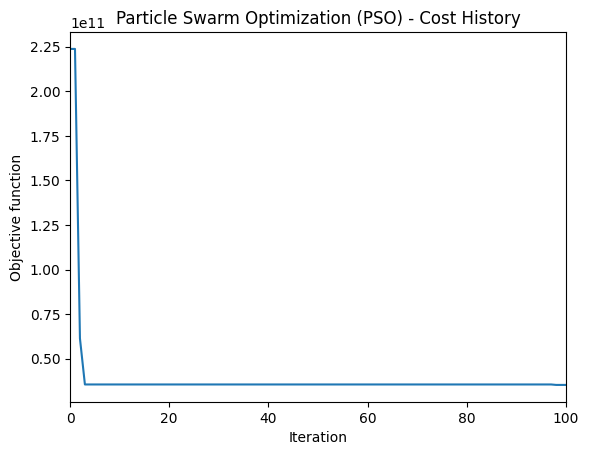

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: 140184120199.7159


In [345]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])

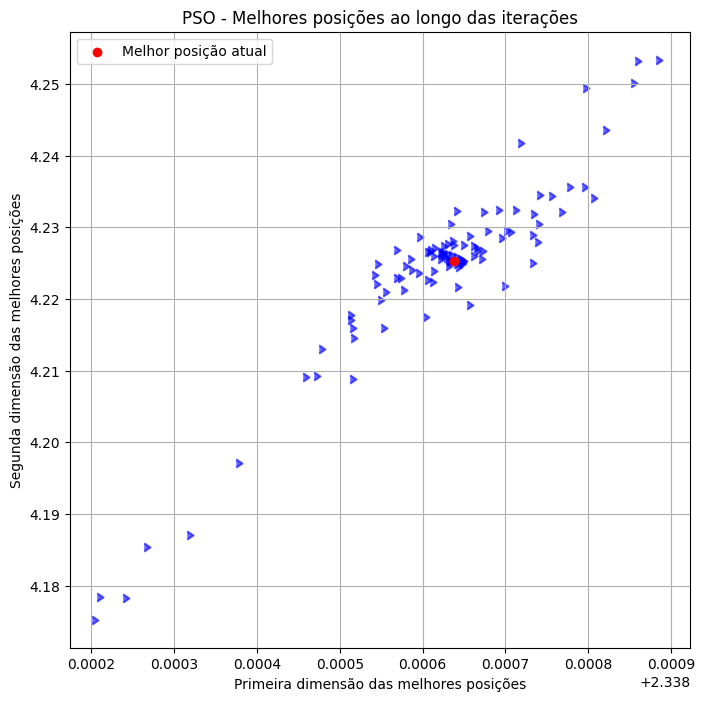

In [346]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker=m, c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()